## Introduction

### Loading libraries

In [67]:
import pandas as pd
import pandas_profiling
import numpy as np

import seaborn as sns

import xgboost as xgb

from sklearn import metrics

from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
import matplotlib

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score as cv
from sklearn.model_selection import train_test_split

In [71]:
from sklearn.model_selection import cross_val_score as cv

In [72]:
import time

### Loading data

In [73]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

### Quick overview of our data:

Happy customers have `TARGET = 0`, unhappy custormers have `TARGET==1`. 
A little less then 4% are unhappy

In [74]:
df = pd.DataFrame(df_train.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/df_train.shape[0]
df

,TARGET,Percentage
0,73012,96.043147
1,3008,3.956853


In [75]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [76]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75818 entries, 0 to 75817
Columns: 370 entries, ID to var38
dtypes: float64(110), int64(260)
memory usage: 214.0 MB


---
## Data Processing

### First, let's go through some of the important features

### 1. `var3`: nationality of the customer

In [77]:
df_train.var3.value_counts()[:10]

 2         74165
 8           138
-999999      116
 9           110
 3           108
 1           105
 13           98
 7            97
 4            86
 12           85
Name: var3, dtype: int64

116 values in column `var3` are -999999, which should mean that the nationality of the customer is unknown

Let's replace -999999 in `var3` column with the most common value 2 

In [78]:
df_train = df_train.replace(-999999,2)

### 2. `num_var4` : number of bank products

Text(0.5,0,'Number of bank products')

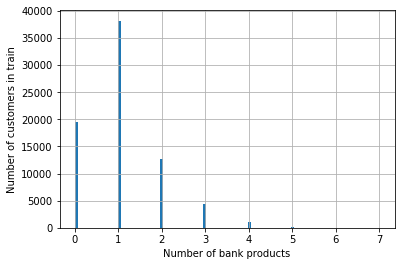

In [79]:
plt = df_train.num_var4.hist(bins=100)
plt.set_ylabel("Number of customers in train")
plt.set_xlabel("Number of bank products")

Looks like most customers have purchased one product from the bank

### 3. Let's now look at the `var38` feature. It is suspected to be the value of the mortgage that a customer has with the bank.

In [80]:
df_train.var38.describe()

count    7.602000e+04
mean     1.172358e+05
std      1.826646e+05
min      5.163750e+03
25%      6.787061e+04
50%      1.064092e+05
75%      1.187563e+05
max      2.203474e+07
Name: var38, dtype: float64

Let's see what `var38` looks like when a customer is unhappy

In [81]:
df_train.loc[df_train.TARGET==1, 'var38'].describe()

count    3.008000e+03
mean     9.967828e+04
std      1.063098e+05
min      1.113663e+04
25%      5.716094e+04
50%      8.621997e+04
75%      1.173110e+05
max      3.988595e+06
Name: var38, dtype: float64

Looks like the mean mortgage has risen quite a bit for unhappy customers. 

---

What are the most common values for `var38`?

In [82]:
df_train.var38.value_counts()

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
236690.340000        8
329603.970000        7
104644.410000        7
67088.310000         7
125722.440000        7
128318.520000        7
97639.560000         6
100466.730000        6
70813.800000         6
163432.470000        6
168733.620000        6
105260.880000        6
185385.690000        6
85814.040000         5
235476.720000        5
121603.020000        5
93037.680000         5
63820.890000         5
33184.020000         5
126065.040000        5
71302.530000         5
208961.790000        5
171932.700000        5
131353.470000        5
127141.500000        5
                 ...  
59680.710000         1
46170.180000         1
75729.810000         1
92730.750000         1
98087.700000         1
31312.410000         1
151944.720000        1
49222.200000         1
46682.640000         1
79753.740000         1
217717.530000        1
156462.240000        1
140446.5900

Looks like there are 14868 of the `117310.979016` value in `var38`. This value is very close to the mean of the column

In [83]:
df_train.var38.mean()

117235.80943035621

Because of this uncommonly high number of this particular entry (`117310.979016`), I think we should logarithmically transform the `var38` feature, to better the results.

In [84]:
df_train['logvar38'] = df_train.loc[~np.isclose(df_train.var38, 117310.979016), 'var38'].map(np.log)

### Removing constant columns

In [85]:
train_cols_to_remove = [col for col in df_train.columns if df_train[col].std() == 0]
test_cols_to_remove = [col for col in df_test.columns if df_test[col].std() == 0]

df_train.drop(train_cols_to_remove, axis=1, inplace=True) 
df_test.drop(test_cols_to_remove, axis=1, inplace=True) 

print("Removed {} constant columns in the train dataframe".format(len(train_cols_to_remove)))
print("Removed {} constant columns in the test dataframe".format(len(test_cols_to_remove)))

Removed 34 constant columns in the train dataframe
Removed 45 constant columns in the test dataframe


### Removing duplicate columns

In [86]:
def rm_dup_cols(df, cols):

    cols_to_remove = []
    
    for i in range(len(cols)-1):
        for j in range(i+1,len(cols)):
            if np.array_equal(df[cols[i]].values, df[cols[j]].values):
                cols_to_remove.append(cols[j])
    return cols_to_remove

In [87]:
train_cols_to_remove = rm_dup_cols(df_train, df_train.columns)
test_cols_to_remove = rm_dup_cols(df_test, df_test.columns)

df_train.drop(train_cols_to_remove, axis=1, inplace=True)
df_test.drop(test_cols_to_remove, axis=1, inplace=True)

print("Removed {} duplicate columns in the train dataframe".format(len(train_cols_to_remove)))
print("Removed {} duplicate columns in the test dataframe".format(len(test_cols_to_remove)))

Removed 29 duplicate columns in the train dataframe
Removed 25 duplicate columns in the test dataframe


### Splitting into the train and test sets

In [88]:
Y = df_train['TARGET'].values
del df_train['TARGET']

# remove the redundant ID column
del df_train['ID']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_train.values, Y, test_size = 0.2, random_state = 42)

---

## Modelling

Let's try different classifiers and see what the accuracy scores are for each of them

In [56]:
def score_model(clf):
    print("\nclassifier: ", clf.__class__.__name__)

    start = time.time()
    
    scores = cv(clf, X_train, y_train, scoring='roc_auc', cv=3) 
    
    print("time (in seconds): {}".format(time.time() - start))
    print("accuracy: {}".format(scores.mean()))
    
    return scores.mean()

In [57]:
scores = dict()

algorithms = [DecisionTreeClassifier(), 
              GaussianNB(), 
              LogisticRegression(), 
              AdaBoostClassifier(),
              RandomForestClassifier(),
              BaggingClassifier(),
              GradientBoostingClassifier()]

for algo in algorithms:
    scores[algo.__class__.__name__] = score_model(algo)


classifier:  DecisionTreeClassifier
time (in seconds): 15.881367921829224
accuracy: 0.5669062944980953

classifier:  GaussianNB
time (in seconds): 3.8030028343200684
accuracy: 0.5139513024488257

classifier:  LogisticRegression
time (in seconds): 12.020312786102295
accuracy: 0.606106398757902

classifier:  AdaBoostClassifier
time (in seconds): 73.64200139045715
accuracy: 0.8207152587149743

classifier:  RandomForestClassifier
time (in seconds): 12.1240074634552
accuracy: 0.6773319209419548

classifier:  BaggingClassifier
time (in seconds): 152.32199335098267
accuracy: 0.696722449064592

classifier:  GradientBoostingClassifier
time (in seconds): 471.66397500038147
accuracy: 0.8332953747611933


---
## Feature selection

Looks like we got the best accuracy from the `Gradient Boosting Classifier`. Let's see how important each feature was for our prediction

In [96]:
X_train.shape

(60816, 307)

In [ ]:
col_mean = np.nanmean(X_train, axis=0)

In [105]:
col_mean
inds = np.where(np.isnan(X_train))
X_train[inds] = np.take(col_mean, inds[1])

In [102]:
np.where(np.isnan(y_train))

(array([], dtype=int64),)

In [106]:
GB_clf = GradientBoostingClassifier()
GB_clf.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Text(0.5,0,'Columns')

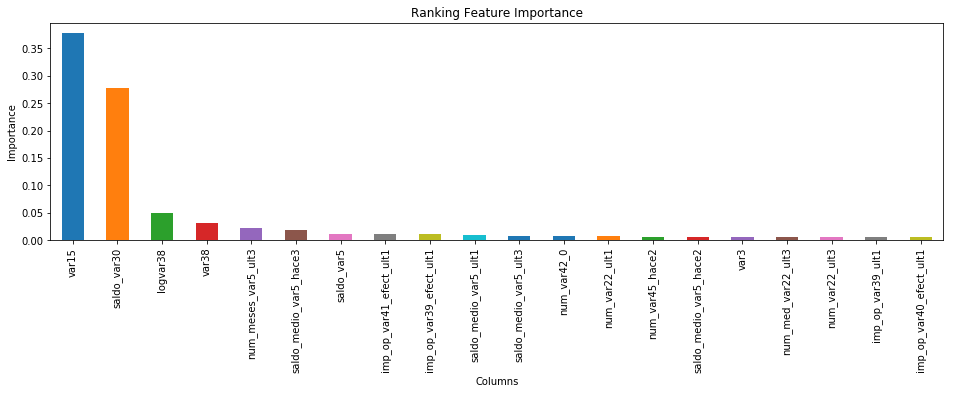

In [111]:
importances = pd.Series(GB_clf.feature_importances_, index = df_train.columns)
importances.sort_values(inplace = True, ascending = False)

plt = importances.head(20).plot(
    kind='bar', 
    figsize=(16, 4), 
    title='Ranking Feature Importance'
)
plt.set_ylabel("Importance")
plt.set_xlabel("Columns")

### Now, let's see our final train and test acuracy

In [60]:
train_acc = GB_clf.score(X_train, y_train)
print("Train accuracy: ", train_acc)

Train accuracy:  0.9615397263877927


In [61]:
test_acc = metrics.accuracy_score(y_test, GB_clf.predict(X_test))
print("Test accuracy: ", test_acc)

Test accuracy:  0.9594843462246777
